## Step 4 Run BikewaySim
---
In this last notebook, the finalized network files are used to calculate the shortest paths between origin-destination pairs. Currently, this code is set up to handle all-to-all pairings of TAZs, but will be modified in the future to take in OD trip tables. This notebook also post processes the shortest path results to calculate metrics and create shapefiles used for visualization.

## Import Modules

In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import itertools
from bikewaysim_lite import *

## Import Files
---
Need to specify the location of the final network, the link impedances to use, and the network with the improved links.

In [2]:
#define fp names
studyarea_name = 'bikewaysim'
dir_fp = Path.home() / Path(f'Documents/NewBikewaySimData/{studyarea_name}')

links = gpd.read_file(dir_fp / 'final_network.gpkg',layer='links')
nodes = gpd.read_file(dir_fp / 'final_network.gpkg',layer='nodes')
tazs = gpd.read_file(dir_fp / 'base_layers.gpkg',layer='tazs')

#include columns with link impedance values in them
impedances = ['costs1']

#read in the improved links
improved_links = gpd.read_file(dir_fp / Path('final_network.gpkg'),layer='improved_links')

#should also have a seperate layer of improved nodes if new nodes were added
#imp_nodes = gpd.read_file('trb2023/network.gpkg',layer='imp_nodes')

## All Possible Origin Destination Pairs Function
---
This block takes in a taz shapefile and outputs an origin-destination (OD) table for using in BikewaySim. If actual/modeled ODs are used, ignore this block and export that file to the directory at the end of this block.

In [ ]:
tazs_id_col = 'OBJECTID'

#import study area and traffic analysis zones being used as the OD pairs
tazs = gpd.read_file(dir_fp/'base_layers.gpkg',layer='tazs')[tazs_id_col,'geometry']]]

#make sure ids are columns
tazs['OBJECTID'] = tazs['OBJECTID'].astype(str)

#get lat and lon columns
tazs.to_crs('epsg:4326',inplace=True)
tazs['lat'] = tazs.geometry.y
tazs['lon'] = tazs.geometry.x

#get permuations of taz ids
perms = list(itertools.permutations(tazs[tazs_id_col],2))

#make df
od_pairs = pd.DataFrame(columns=['trip_id','ori_id','dest_id','ori_lat','ori_lon','dest_lat','dest_lon'])

od_pairs['perms'] = perms
#seperate into two columns

od_pairs = pd.merge(od_pairs,tazs,left_on='ori_id',right_on=tazs_id_col)
od_pairs.rename(columns={'lat':'ori_lat','lon':'ori_lon'},inplace=True)

od_pairs = pd.merge(od_pairs,tazs,left_on='dest_id',right_on=tazs_id_col)
od_pairs.rename(columns={'lat':'dest_lat','lon':'dest_lon'},inplace=True)

od_pairs['trip_id'] = od_pairs['ori_id'] + '_' + od_pairs['dest_id']

#export
od_pairs.to_csv(dir_fp / 'od_pairs.csv', index = False)
od_pairs.head()


## Snapping ods to network
---
This function finds the nearest network node from an origin/destination and calculates the time it would take walk using Euclidean distance (as the crow flies).

In [3]:
#get network nodes
ods = snap_ods_to_network(od_pairs,nodes)

#need one for improved nodes if new nodes were added
#ods_improved = snap_ods_to_network(ods_pairs,improved_nodes)

# Bikesheds
---
This block calculates the bikesheds for a given network node, impedances, and a set of constraints.

c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


---69431331---
Bikeshed Network Miles: 21.995389632205985
Bikeshed Size (square miles w/10 ft access distance): 1.730713580668756


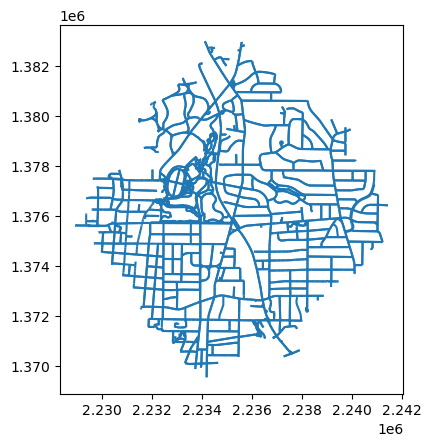

In [4]:
bikeshed = {}
improved_bikeshed = {}
origin = '69431331'#'2044581325' # network node to calculate bikeshed for (reference snapped ods)
#origin = ods.loc[ods['ori_id']==taz,'o_node'].unique().item() # or use this to lookup network node given taz id
radius = 10 # time limit in minutes
buffer_size = 100 # if determining area instead of linear network miles, set access distance in ft

#just time based
bikeshed['mins'], bikeshed_node = make_bikeshed(links,nodes,origin,radius,buffer_size,'mins')
bikeshed['mins'].plot()

#export
bikeshed['mins'].to_file(dir_fp / 'bikesheds.gpkg',layer='mins')
bikeshed_node.to_file(dir_fp / 'bikesheds.gpkg',layer='origin')

In [5]:
#create a bikeshed by going through each impedance column
for impedance in impedances:
    bikeshed[impedance], bikeshed_node = make_bikeshed(links,nodes,taz,ods,radius,buffer_size,impedance)
    bikeshed[impedance].to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='bikeshed')

    #find removed links (can no longer be reached)
    rem_links = bikeshed['mins'][-(bikeshed['mins']['A_B'].isin(bikeshed[impedance]['A_B']))]
    if rem_links.shape[0] > 0:
        rem_links.to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='removed')

    #find added links (can now be reached)
    add_links = bikeshed[impedance][-bikeshed[impedance]['A_B'].isin(bikeshed['mins']['A_B'])]
    if add_links.shape[0] > 0:
        add_links.to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='add')

c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


---69431331---
Bikeshed Network Miles: 14.534138341672147
Bikeshed Size (square miles w/10 ft access distance): 1.1084666769414933


In [6]:
#for the improved network
for impedance in impedances:
    bikeshed['improved' + impedance], _ = make_bikeshed(improved_links,nodes,taz,ods,radius,buffer_size,impedance)
    bikeshed['improved' + impedance].to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='improved_bikeshed')

    #find added links from improvement
    add_impr = bikeshed['improved'+impedance]
    add_impr = add_impr[-add_impr['A_B'].isin(bikeshed[impedance]['A_B'])]
    if add_impr.shape[0] > 0:
        add_impr.to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='improvment add')
    else:
        print('No new links added')

c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


---69431331---
Bikeshed Network Miles: 15.640098954481806
Bikeshed Size (square miles w/10 ft access distance): 1.19872408861438


# Run shortest path
---
The find shortest function finds and returns the shortest path between unique origin-destination pairs using the impedance column specified.

In [7]:
#shortest distance version
ods_dist, links, nodes = find_shortest(links, nodes, ods, 'mins')

100%|██████████| 169/169 [00:57<00:00,  2.94it/s]
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


335 trips couldnt be routed


In [8]:
#impedance version
ods_imp, links, nodes = find_shortest(links, nodes, ods, 'costs1')

100%|██████████| 169/169 [00:56<00:00,  2.99it/s]
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


335 trips couldnt be routed


In [9]:
#network improvements (replace with imp_nodes)
ods_improved, improved_links, nodes = find_shortest(improved_links, nodes, ods, 'costs1')

100%|██████████| 169/169 [00:57<00:00,  2.95it/s]
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


335 trips couldnt be routed


## Individual Routing

In [11]:
#pairs
imp_trip = ods_imp[ods_imp['trip_id'] == "544_630"]
dist_trip = ods_dist[ods_dist['trip_id'] == "544_630"]

print(imp_trip['length'].item() / 5280)
print(dist_trip['length'].item() / 5280)
print((imp_trip['length'].item() - dist_trip['length'].item() ) / dist_trip['length'].item())

origin = centroids[centroids['OBJECTID']==dist_trip['ori_id'].item()]
dest = centroids[centroids['OBJECTID']==dist_trip['dest_id'].item()]

imp_trip.to_file(dir_fp / "individual_routing.gpkg", layer = 'imp path')
dist_trip.to_file(dir_fp / "individual_routing.gpkg", layer = 'dist path')
origin[['OBJECTID','geometry']].to_file(dir_fp / "individual_routing.gpkg", layer = 'origin')
dest[['OBJECTID','geometry']].to_file(dir_fp / "individual_routing.gpkg", layer = 'dest')

3.593051054576389
2.746763879842245
0.30810335789865906


In [12]:
#pairs
improved_trip = ods_improved[ods_improved['trip_id'] == "562_531"]
imp_trip = ods_imp[ods_imp['trip_id']=="562_531"]
dist_trip = ods_dist[ods_dist['trip_id'] == "562_531"]

print(imp_trip['length'].item() / 5280)
print(dist_trip['length'].item() / 5280)
print(improved_trip['length'].item() / 5280)
print((imp_trip['length'].item() - dist_trip['length'].item() ) / dist_trip['length'].item())
print((improved_trip['length'].item() - dist_trip['length'].item() ) / dist_trip['length'].item())

origin = centroids[centroids['OBJECTID']==dist_trip['ori_id'].item()]
dest = centroids[centroids['OBJECTID']==dist_trip['dest_id'].item()]

improved_trip.to_file(dir_fp / "individual_routing_w_improvement.gpkg", layer = 'improved path')
imp_trip.to_file(dir_fp / "individual_routing_w_improvement.gpkg", layer = 'imp path')
dist_trip.to_file(dir_fp / "individual_routing_w_improvement.gpkg", layer = 'dist path')

origin[['OBJECTID','geometry']].to_file(dir_fp / "individual_routing_w_improvement.gpkg", layer = 'origin')
dest[['OBJECTID','geometry']].to_file(dir_fp / "individual_routing_w_improvement.gpkg", layer = 'dest')

3.91003811543309
3.5164697728047636
3.7138642636364736
0.11192143486403783
0.05613427772315709


## Betweenness Centrality

In [13]:
#find difference in btw centrality
links['btw_difference'] =  links['costs1_btw_cntrlty'] - links['mins_btw_cntrlty'] 
links['btw_diff'] = "Small (less than 300) Change in Betweenness Centrality"
links.loc[links['btw_difference'] > 300,'btw_diff'] = 'Increased Betweenness Centrality'
links.loc[links['btw_difference'] < -300,'btw_diff'] = 'Decreased Betweenness Centrality'

links.to_file(dir_fp/'btw_centrality.gpkg',layer='links')
improved_links.to_file(dir_fp/'btw_centrality.gpkg',layer='improved_links')

In [ ]:
tazs = gpd.read_file(dir_fp / "base_layers.gpkg", layer='tazs')
centroids = gpd.read_file(dir_fp / "base_layers.gpkg", layer='centroids')

#make sure objectid is str
tazs['OBJECTID'] = tazs['OBJECTID'].astype(str)

## Percent Detour

In [14]:
#cacluate pct detour
by_taz_imp = percent_detour(ods_dist,ods_imp,tazs)
by_taz_imp = gpd.GeoDataFrame(by_taz_imp,geometry='geometry',crs=ods_dist.crs)
by_taz_imp.to_file(dir_fp/'zonal.gpkg',layer='percent_detour')
#by_taz_improved = percent_detour(ods_dist,ods_improved,tazs)

In [18]:
by_taz_imp['percent_detour'].mean()

21.39090909090909

## Change in Impedance

In [15]:
by_taz_improved = impedance_change(ods_imp,ods_improved,tazs,'costs1')
by_taz_improved = gpd.GeoDataFrame(by_taz_improved,geometry='geometry',crs=ods_dist.crs)
by_taz_improved.to_file(dir_fp/'zonal.gpkg',layer='imp_change')

In [24]:
by_taz_just_pbl = impedance_change(ods_imp,ods_pbl,tazs,'costs1')
by_taz_just_pbl = gpd.GeoDataFrame(by_taz_just_pbl,geometry='geometry',crs=ods_dist.crs)
by_taz_just_pbl['imp_change'].mean()

0.3894177826165851

In [26]:
by_taz_just_path = impedance_change(ods_imp,ods_path,tazs,'costs1')
by_taz_just_path = gpd.GeoDataFrame(by_taz_just_path,geometry='geometry',crs=ods_dist.crs)
by_taz_just_path['imp_change'].mean()

0.7838433868999597

In [20]:
by_taz_improved['imp_change'].mean()

1.173261169516545

## Basic Stats

In [16]:
#basic stats
#find avg impedance
ods.dist.mean()
ods.per_dist.mean()
ods.imp_dist.mean()

AttributeError: 'DataFrame' object has no attribute 'dist'

Deprecated Code

In [ ]:
# just_pbl = gpd.read_file(dir_fp / 'final_network.gpkg',layer='just_pbl_links')
# just_path = gpd.read_file(dir_fp / 'final_network.gpkg',layer='just_path_links')

# ods_pbl, just_pbl, nodes = find_shortest(just_pbl, nodes, ods, 'costs1')
# ods_path, just_path, nodes = find_shortest(just_path, nodes, ods, 'costs1')